<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/DeepLearningCNN/blob/main/classificacaocaogatotensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Imagens 

Este tutorial mostra como classificar cães ou gatos a partir de imagens. Ele constrói um classificador de imagem usando um modelo tf.keras.Sequential e carrega dados usando tf.keras.preprocessing.image.ImageDataGenerator. Você obterá alguma experiência prática e desenvolverá intuição para os seguintes conceitos:

Construir pipelines de entrada de dados usando a classe tf.keras.preprocessing.image.ImageDataGenerator para trabalhar de forma eficiente com dados no disco para usar com o modelo.
Overfitting - Como identificá-lo e evitá-lo.
Aumento e abandono de dados - técnicas-chave para combater o sobreajuste em tarefas de visão computacional para incorporar no pipeline de dados e no modelo de classificador de imagem.
Este tutorial segue um fluxo de trabalho básico de aprendizado de máquina:

1. Examine e compreenda os dados
2. Construir um pipeline de entrada
3. Construir o modelo
4. Treine o modelo
5. Teste o modelo
6. Melhore o modelo e repita o processo



## Importar pacotes

Vamos começar importando os pacotes necessários. O pacote os é usado para ler arquivos e estrutura de diretório, NumPy é usado para converter a lista python em numpy array e para executar as operações de matriz necessárias e matplotlib.pyplot para traçar o gráfico e exibir imagens nos dados de treinamento e validação.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

Importa Tensorflow e o Keras necessário para construir o nosso modelo

In [2]:
#try:
#  # %tensorflow_version only exists in Colab.
#  %tensorflow_version 2.x
#except Exception:
#  pass

import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
#print("GPU Available:", tf.test.is_gpu_available())
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.7.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Le dados

Begin by downloading the dataset. This tutorial uses a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> dataset from Kaggle. Download the archive version of the dataset and store it in the "/tmp/" directory.

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68616192/68606236 [==============================] - 1s 0us/step


A estrutura do dataset:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Depois de extrair seu conteúdo, atribua variáveis com o caminho de arquivo adequado para o conjunto de treinamento e validação.

In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [6]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understand the data

Vejamos quantas imagens de cães e gatos estão no diretório de treinamento e validação:

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


Por conveniência, configure variáveis para usar enquanto pré-processa o conjunto de dados e treina a rede.

In [9]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Preparação de dados

Formate as imagens em tensores de ponto flutuante devidamente pré-processados antes de alimentar a rede:

1. Leia as imagens do disco.
2. Decodifique o conteúdo dessas imagens e converta-o no formato de grade adequado de acordo com seu conteúdo RGB.
3. Converta-os em tensores de ponto flutuante.
4. Redimensione os tensores de valores entre 0 e 255 para valores entre 0 e 1, pois as redes neurais preferem lidar com pequenos valores de entrada.

Felizmente, todas essas tarefas podem ser feitas com a classe `ImageDataGenerator` fornecida por` tf.keras`. Ele pode ler imagens do disco e pré-processá-las em tensores adequados. Ele também configurará geradores que convertem essas imagens em lotes de tensores - úteis no treinamento da rede.

In [10]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

Depois de definir os geradores para imagens de treinamento e validação, o método flow_from_directory carrega imagens do disco, aplica o redimensionamento e redimensiona as imagens para as dimensões necessárias.

In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [12]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualize as imagens do treinamento

Visualize as imagens de treinamento extraindo um lote de imagens do gerador de treinamento - que são 32 imagens neste exemplo - e plote cinco delas com matplotlib.

In [13]:
sample_training_images, _ = next(train_data_gen)

A função `next` retorna um lote do conjunto de dados. O valor de retorno da função `next` está na forma de` (x_train, y_train) `onde x_train é recursos de treinamento e y_train, seus rótulos. Descarte os rótulos para visualizar apenas as imagens de treinamento.

In [14]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

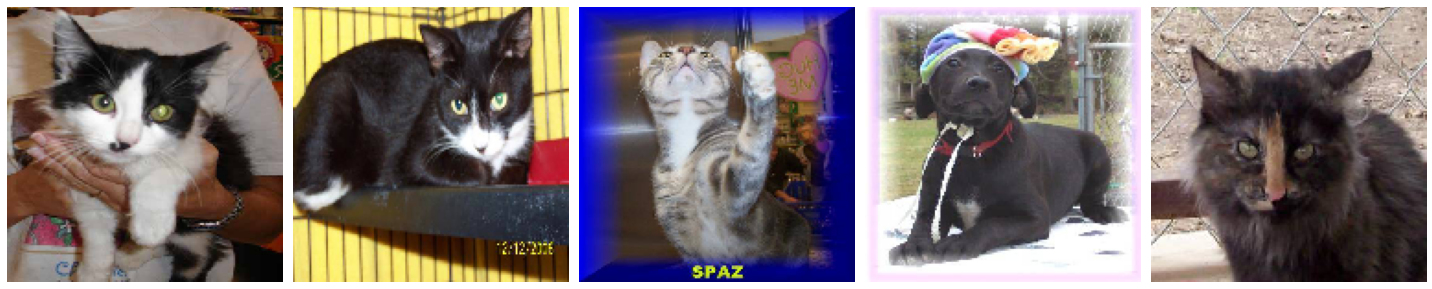

In [15]:
plotImages(sample_training_images[:5])

## Cria o modelo

O modelo consiste em três blocos de convolução com uma camada máxima de pool em cada um deles. Há uma camada totalmente conectada com 512 unidades em cima dela que é ativada por uma função de ativação relu. O modelo gera probabilidades de classe com base na classificação binária pela função de ativação sigmóide.

In [16]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Compile o modelo

Para este tutorial, escolha o otimizador * ADAM * e a função de perda de * entropia cruzada binária *. Para visualizar a precisão do treinamento e da validação para cada período de treinamento, passe o argumento `metrics`.

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Modelo sumário

Visualize todas as camadas da rede usando o método `summary` do modelo:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

### treina o modelo

Use o método fit_generator da classe ImageDataGenerator para treinar a rede.

In [19]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/15
15/15 [==============================] - 22s 662ms/step - loss: 0.8804 - accuracy: 0.5123 - val_loss: 0.6970 - val_accuracy: 0.4955
Epoch 2/15
15/15 [==============================] - 9s 616ms/step - loss: 0.6773 - accuracy: 0.5729 - val_loss: 0.6441 - val_accuracy: 0.6462
Epoch 3/15
15/15 [==============================] - 9s 623ms/step - loss: 0.6275 - accuracy: 0.6416 - val_loss: 0.6295 - val_accuracy: 0.6116
Epoch 4/15
15/15 [==============================] - 9s 610ms/step - loss: 0.5821 - accuracy: 0.6886 - val_loss: 0.6472 - val_accuracy: 0.5971
Epoch 5/15
15/15 [==============================] - 9s 611ms/step - loss: 0.5669 - accuracy: 0.7051 - val_loss: 0.6101 - val_accuracy: 0.6797
Epoch 6/15
15/15 [==============================] - 9s 621ms/step - loss: 0.5269 - accuracy: 0.7420 - val_loss: 0.6315 - val_accuracy: 0.6775
Epoch 7/15
15/15 [==============================] - 9s 613ms/step - loss: 0.4907 - accuracy: 0.7644 - val_loss: 0.5829 - val_accuracy: 0.7087
Epoch

### Visualiza o resultado do treinamento

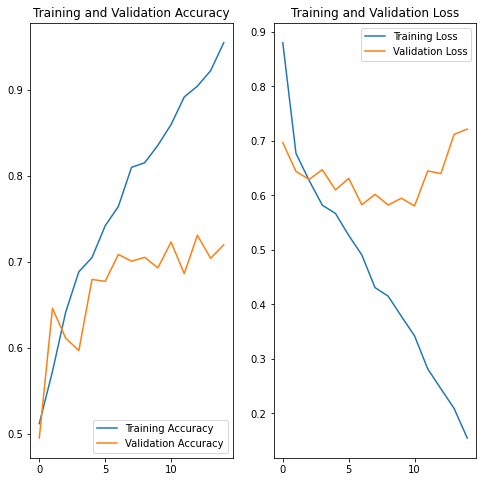

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Como você pode ver nos gráficos, a precisão do treinamento e a precisão da validação estão erradas por uma grande margem e o modelo atingiu apenas cerca de 70% de precisão no conjunto de validação.

Vamos ver o que deu errado e tentar aumentar o desempenho geral do modelo.

## Overfitting

Nos gráficos acima, a precisão do treinamento está aumentando linearmente com o tempo, enquanto a precisão da validação para em torno de 70% no processo de treinamento. Além disso, a diferença na precisão entre a precisão do treinamento e da validação é perceptível - um sinal de * sobreajuste *.

Quando há um pequeno número de exemplos de treinamento, o modelo às vezes aprende com ruídos ou detalhes indesejados de exemplos de treinamento - a um ponto que afeta negativamente o desempenho do modelo em novos exemplos. Esse fenômeno é conhecido como overfitting. Isso significa que o modelo terá dificuldade em generalizar em um novo conjunto de dados.

Existem várias maneiras de combater o sobreajuste no processo de treinamento. Neste tutorial, você usará * aumento de dados * e adicionará * dropout * ao nosso modelo.

## Data augmentation

O overfitting geralmente ocorre quando há um pequeno número de exemplos de treinamento. Uma maneira de corrigir esse problema é aumentar o conjunto de dados para que tenha um número suficiente de exemplos de treinamento. O aumento de dados adota a abordagem de gerar mais dados de treinamento a partir de amostras de treinamento existentes, aumentando as amostras usando transformações aleatórias que produzem imagens de aparência confiável. O objetivo é que o modelo nunca verá exatamente a mesma imagem duas vezes durante o treinamento. Isso ajuda a expor o modelo a mais aspectos dos dados e generalizar melhor.

Implemente isso em `tf.keras` usando a classe` ImageDataGenerator`. Passe diferentes transformações para o conjunto de dados e ele se encarregará de aplicá-las durante o processo de treinamento.

### aumento e vizualização de dados

Comece aplicando aumento aleatório de giro horizontal ao conjunto de dados e veja como as imagens individuais ficam após a transformação.

### aplicando horizontal flip

Passe `horizontal_flip` como um argumento para a classe` ImageDataGenerator` e defina-o como `True` para aplicar este aumento.

In [21]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [22]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


Pegue uma imagem de amostra dos exemplos de treinamento e repita-a cinco vezes para que o aumento seja aplicado à mesma imagem cinco vezes.

In [23]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

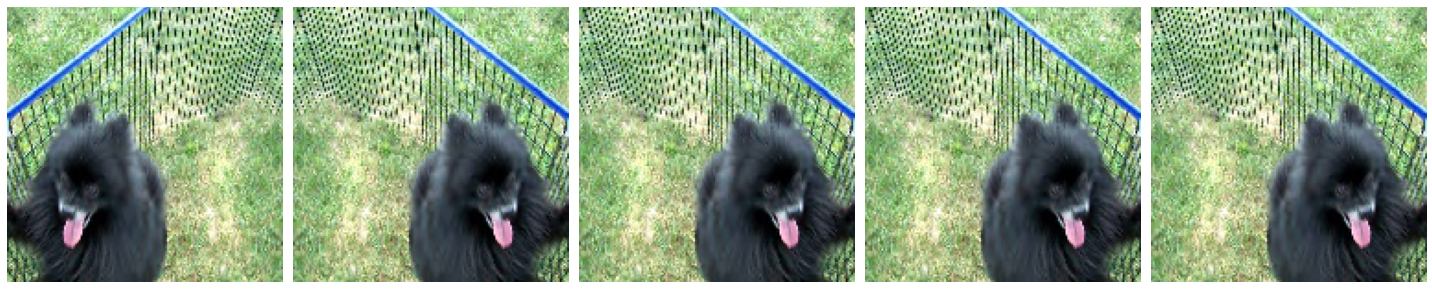

In [24]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### rotação randomica de imagem

Vamos dar uma olhada em um aumento diferente chamado rotação e aplicar 45 graus de rotação aleatoriamente aos exemplos de treinamento.

In [25]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [26]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


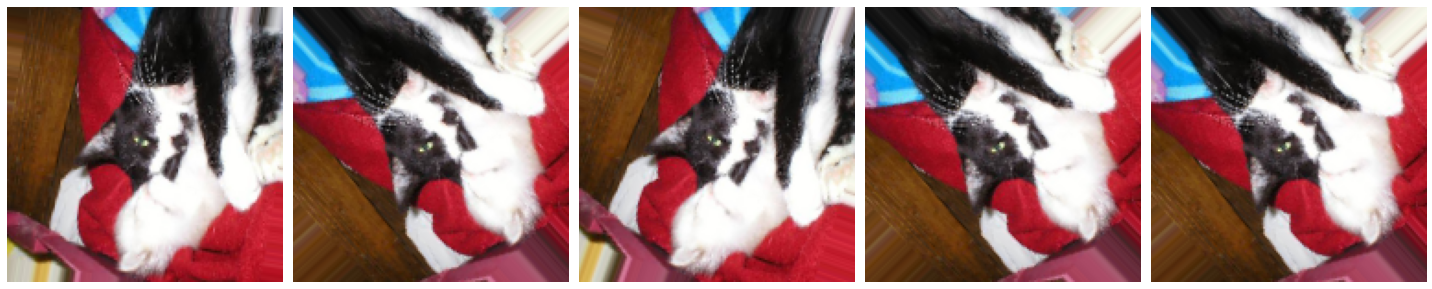

In [27]:
plotImages(augmented_images)

### aplicando zoom augmentation

Aplique um aumento de zoom ao conjunto de dados para ampliar as imagens em até 50% aleatoriamente.

In [28]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [29]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


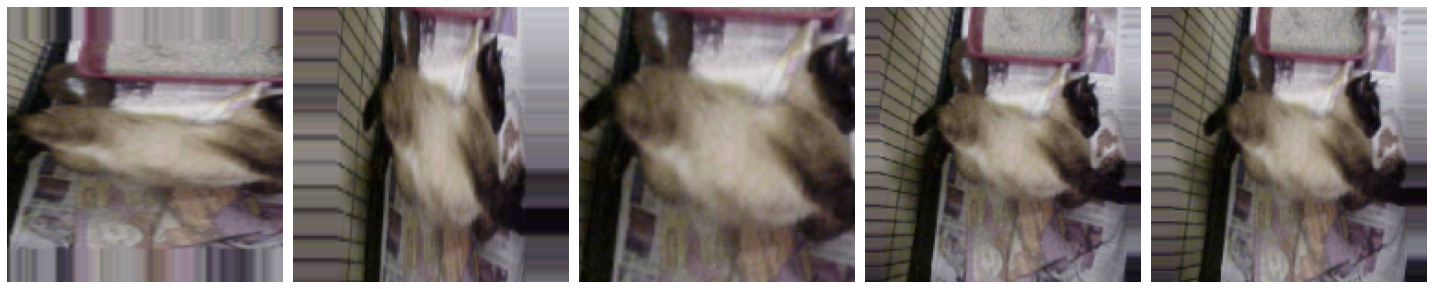

In [30]:
plotImages(augmented_images)

### Juntar tudo

Aplique todos os aumentos anteriores. Aqui, você aplicou redimensionamento, rotação de 45 graus, deslocamento de largura, deslocamento de altura, inversão horizontal e aumento de zoom às imagens de treinamento.

In [31]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [32]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Visualize como uma única imagem ficaria cinco vezes diferentes ao passar esses aumentos aleatoriamente para o conjunto de dados.

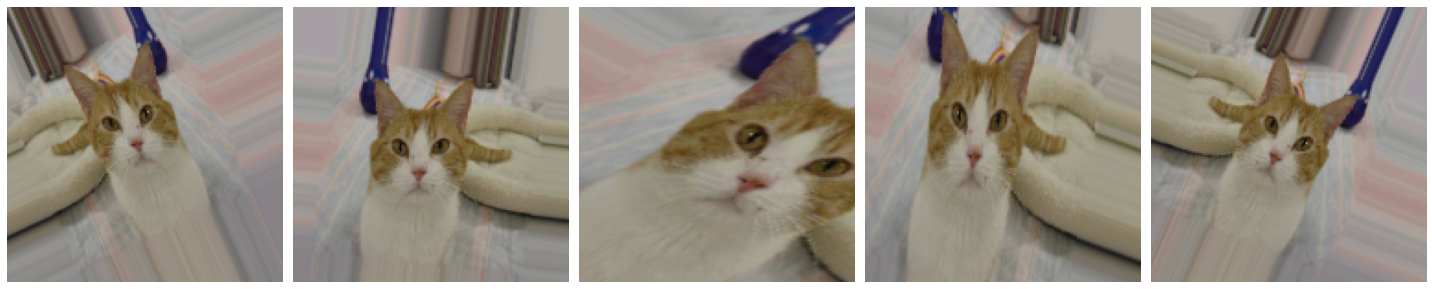

In [33]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Cria dados de validação 

Geralmente, aplique aumento de dados apenas aos exemplos de treinamento. Nesse caso, apenas redimensione as imagens de validação e converta-as em lotes usando `ImageDataGenerator`.

In [34]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [35]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Dropout

Outra técnica para reduzir o sobreajuste é introduzir o abandono na rede. É uma forma de regularização que força os pesos na rede a assumirem apenas pequenos valores, o que torna a distribuição dos valores de peso mais regular e a rede pode reduzir o overfitting em pequenos exemplos de treinamento. Dropout é uma das técnicas de regularização usadas neste tutorial

Quando você aplica a eliminação a uma camada, ela elimina aleatoriamente (definido como zero) o número de unidades de saída da camada aplicada durante o processo de treinamento. O dropout leva um número fracionário como seu valor de entrada, na forma como 0,1, 0,2, 0,4, etc. Isso significa retirar 10%, 20% ou 40% das unidades de saída aleatoriamente da camada aplicada.

Ao aplicar 0,1 abandono a uma determinada camada, ele mata aleatoriamente 10% das unidades de saída em cada época de treinamento.

Crie uma arquitetura de rede com este novo recurso de eliminação e aplique-o a diferentes convoluções e camadas totalmente conectadas.

## Criando uma nova rede com Droupouts 

Aqui, você aplica a eliminação à primeira e à última camadas máximas do pool e a uma camada totalmente conectada que possui 512 unidades de saída. 30% da primeira e da última camada máxima do pool e 10% das unidades de saída da camada totalmente conectada são definidas aleatoriamente para zero durante cada período de treinamento.

In [36]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Compila o modelo

Depois de introduzir dropouts na rede, compile o modelo e visualize o resumo das camadas.

In [37]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 64)       

### Treine o modelo

Depois de introduzir com sucesso aumentos de dados nos exemplos de treinamento e adicionar desistências à rede, treine esta nova rede:

In [38]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/15
15/15 [==============================] - 20s 1s/step - loss: 1.3043 - accuracy: 0.4947 - val_loss: 0.6924 - val_accuracy: 0.4933
Epoch 2/15
15/15 [==============================] - 19s 1s/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.4978
Epoch 3/15
15/15 [==============================] - 19s 1s/step - loss: 0.6928 - accuracy: 0.5078 - val_loss: 0.6920 - val_accuracy: 0.5725
Epoch 4/15
15/15 [==============================] - 19s 1s/step - loss: 0.6913 - accuracy: 0.5385 - val_loss: 0.6971 - val_accuracy: 0.4967
Epoch 5/15
15/15 [==============================] - 19s 1s/step - loss: 0.6920 - accuracy: 0.5118 - val_loss: 0.6899 - val_accuracy: 0.5145
Epoch 6/15
15/15 [==============================] - 19s 1s/step - loss: 0.6891 - accuracy: 0.5513 - val_loss: 0.6848 - val_accuracy: 0.5469
Epoch 7/15
15/15 [==============================] - 19s 1s/step - loss: 0.6823 - accuracy: 0.5636 - val_loss: 0.6896 - val_accuracy: 0.5223
Epoch 8/15
15/15 [==

### Visualize o modelo

Visualize o novo modelo após o treinamento, você pode ver que há muito menos overfitting do que antes. A precisão deve aumentar depois de treinar o modelo para mais épocas.

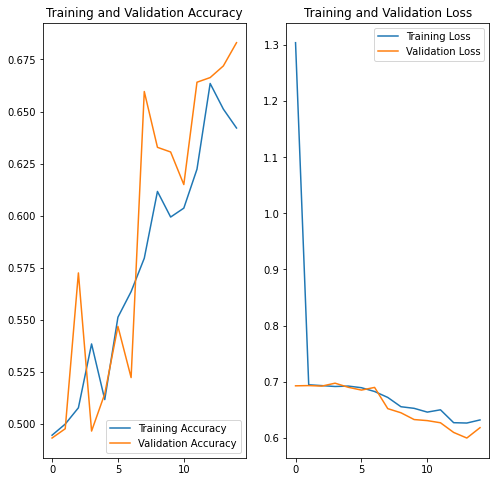

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()